## CMSC - 673 Project

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import iplot, init_notebook_mode
## for dataframe iplot
import cufflinks

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
cufflinks.go_offline(connected=True)

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import nltk
import gensim
import spacy
from tensorflow.keras import preprocessing  
import re

In [3]:
from gensim.models import KeyedVectors
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from scipy.sparse import hstack

In [4]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

In [5]:
df = pd.read_csv("data/train.csv")
# df = pd.read_csv("data/sample_submission.csv")

In [6]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,...,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,...,2006,rejected,0,0,0,1,0,0.0,4,47


In [7]:
df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count'],
      dtype='object')

In [8]:
# 0 -> Non-Toxic; 1 -> Toxic
df['isToxic'] = [1 if x >= 0.5 else 0 for x in df['target']]

In [9]:
df.head(2)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,isToxic
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,rejected,0,0,0,0,0,0.0,0,4,0


In [10]:
len(df)

1804874

In [11]:
df.dropna(axis=0, inplace=True)

In [12]:
len(df)

235087

In [13]:
df.columns

Index(['id', 'target', 'comment_text', 'severe_toxicity', 'obscene',
       'identity_attack', 'insult', 'threat', 'asian', 'atheist', 'bisexual',
       'black', 'buddhist', 'christian', 'female', 'heterosexual', 'hindu',
       'homosexual_gay_or_lesbian', 'intellectual_or_learning_disability',
       'jewish', 'latino', 'male', 'muslim', 'other_disability',
       'other_gender', 'other_race_or_ethnicity', 'other_religion',
       'other_sexual_orientation', 'physical_disability',
       'psychiatric_or_mental_illness', 'transgender', 'white', 'created_date',
       'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow',
       'sad', 'likes', 'disagree', 'sexual_explicit',
       'identity_annotator_count', 'toxicity_annotator_count', 'isToxic'],
      dtype='object')

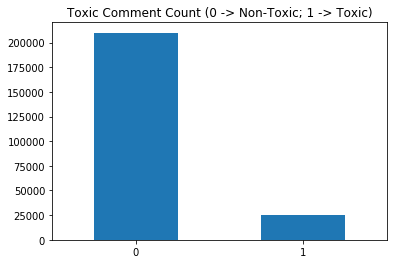

In [14]:
df['isToxic'].value_counts().plot(kind='bar',title='Toxic Comment Count (0 -> Non-Toxic; 1 -> Toxic)',rot=0) 
#, xTitle='0 -> Non-Toxic; 1 -> Toxic', yTitle='Counts'

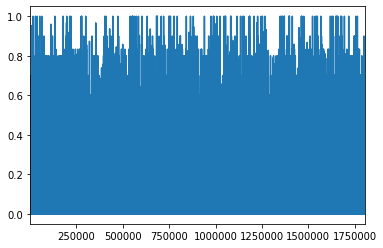

In [15]:
df['identity_attack'].plot()

In [10]:
comments = df['comment_text']

In [11]:
import string
def remove_punc(text):
    no_punc_text = ""
    prev_char = ''
    for char in text:
#         print(char)
        if char not in string.punctuation:
            no_punc_text += char
#             prev_char = char
        elif prev_char not in string.punctuation and prev_char != ' ':
            no_punc_text += ' '
        prev_char = char
    return no_punc_text        

In [12]:
df['comment'] = df['comment_text'].apply(lambda x: remove_punc(x))
# comment = df['comment_text'][:2].apply(lambda x: remove_punc(x))
df.head(2)
# comment[1]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,isToxic,comment
0,59848,0.0,"This is so cool. It's like, 'would you want yo...",0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0,0,0,0.0,0,4,0,This is so cool It s like would you want you...
1,59849,0.0,Thank you!! This would make my life a lot less...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,0,0,0,0,0,0.0,0,4,0,Thank you This would make my life a lot less ...


In [13]:
df['comment_text'][:1], df['comment'][:1]

(0    This is so cool. It's like, 'would you want yo...
 Name: comment_text, dtype: object,
 0    This is so cool  It s like  would you want you...
 Name: comment, dtype: object)

In [14]:
df['comment_word'] = [[word for word in comt.split()] for comt in df['comment']]
# comments = [comt for comt in df['comment'][:10]]

In [15]:
comments

0          This is so cool. It's like, 'would you want yo...
1          Thank you!! This would make my life a lot less...
2          This is such an urgent design problem; kudos t...
3          Is this something I'll be able to install on m...
4                       haha you guys are a bunch of losers.
                                 ...                        
1804869    Maybe the tax on "things" would be collected w...
1804870    What do you call people who STILL think the di...
1804871    thank you ,,,right or wrong,,, i am following ...
1804872    Anyone who is quoted as having the following e...
1804873    Students defined as EBD are legally just as di...
Name: comment_text, Length: 1804874, dtype: object

In [24]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,isToxic,comment,comment_word
11,239579,0.4400,This is a great story. Man. I wonder if the pe...,0.00,0.293333,0.0000,0.3200,0.0000,0.0,0.0,...,0,0,1,0,0.04,10,75,0,This is a great story Man I wonder if the pe...,"[This, is, a, great, story, Man, I, wonder, if..."
31,239607,0.9125,Yet call out all Muslims for the acts of a few...,0.05,0.237500,0.6125,0.8875,0.1125,0.0,0.0,...,0,0,1,0,0.00,4,80,1,Yet call out all Muslims for the acts of a few...,"[Yet, call, out, all, Muslims, for, the, acts,..."
51,239644,0.0000,Because the people who drive cars more are the...,0.00,0.000000,0.0000,0.0000,0.0000,0.0,0.0,...,0,0,0,0,0.00,4,4,0,Because the people who drive cars more are the...,"[Because, the, people, who, drive, cars, more,..."
58,239653,0.3000,Mormons have had a complicated relationship wi...,0.00,0.000000,0.3000,0.0000,0.0000,0.0,0.0,...,0,0,2,0,0.00,10,10,0,Mormons have had a complicated relationship wi...,"[Mormons, have, had, a, complicated, relations..."
111,239744,0.0000,I'm doing the same thing! :),0.00,0.000000,0.0000,0.0000,0.0000,0.0,0.0,...,0,0,1,0,0.00,4,4,0,I m doing the same thing,"[I, m, doing, the, same, thing]"


In [25]:
df[df['severe_toxicity'] > 0]['severe_toxicity']

31         0.050000
563        0.100000
649        0.049383
703        0.014706
1597       0.200000
             ...   
1804386    0.200000
1804405    0.100000
1804478    0.013333
1804524    0.033333
1804532    0.100000
Name: severe_toxicity, Length: 18045, dtype: float64

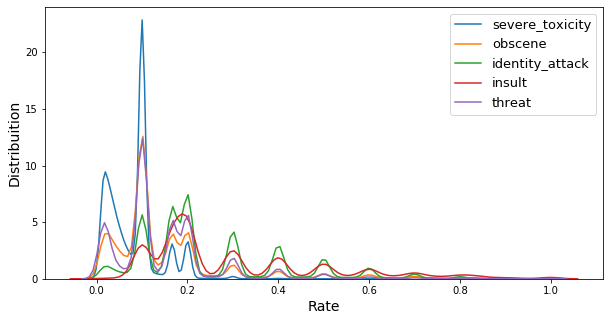

In [26]:
toxic_cmt = ['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']

plt.figure(figsize=(10,5))

for col in toxic_cmt[1:]:
    g = sns.distplot(df[df[col] > 0][col], label=col, hist = False)    
    
plt.xlabel("Rate", fontsize=14)
plt.ylabel("Distribuition", fontsize=14)
plt.legend(loc=1, prop={'size': 13}) 
plt.title("")
plt.show()

### SVM Model Baseline + TfIdf Default

In [29]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["comment_text"])
y = df['isToxic']

In [30]:
# print(X[:10])

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [32]:
svc_clf1 = SVC(gamma='auto')
svc_clf1.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
pred = svc_clf1.predict(X_test)
pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
print(classification_report(y_test, pred))
print("\nAccuracy:  ", accuracy_score(y_test,pred))
print("\nPrecision: ", precision_score(y_test,pred))
print("\nRecall:    ", recall_score(y_test,pred))
print("\nF1 Score:  ", f1_score(y_test,pred))
print("\nROC AUC Score: ", roc_auc_score(y_test,pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     69308
           1       0.00      0.00      0.00      8271

   micro avg       0.89      0.89      0.89     77579
   macro avg       0.45      0.50      0.47     77579
weighted avg       0.80      0.89      0.84     77579


Accuracy:   0.8933860967529873

Precision:  0.0

Recall:     0.0

F1 Score:   0.0

ROC AUC Score:  0.5


#### Since the dataset is imbalanced, the model seems to be learning for only majority class and not generalizing.

### With Undersampling

In [35]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

Using TensorFlow backend.


In [36]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled).items()))

[(0, 16871), (1, 16871)]


#### SVC + TfIdf

In [37]:
svc_clf2 = SVC(gamma='auto')
svc_clf2.fit(X_resampled, y_resampled)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [38]:
svc_pred = svc_clf2.predict(X_test)
print(classification_report(y_test, svc_pred))
print("\nAccuracy:  ", accuracy_score(y_test,svc_pred))
print("\nPrecision: ", precision_score(y_test,svc_pred))
print("\nRecall:    ", recall_score(y_test,svc_pred))
print("\nF1 Score:  ", f1_score(y_test,svc_pred))
print("\nROC AUC Score: ", roc_auc_score(y_test,svc_pred))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94     69308
           1       0.43      0.16      0.23      8271

   micro avg       0.89      0.89      0.89     77579
   macro avg       0.67      0.57      0.59     77579
weighted avg       0.86      0.89      0.86     77579


Accuracy:   0.8879593704481883

Precision:  0.43176661264181526

Recall:     0.16104461371055495

F1 Score:   0.23458964424092993

ROC AUC Score:  0.5678758591147569


#### Multinomial NB + TfIDF 

In [39]:
mnb = MultinomialNB()
mnb.fit(X_resampled.toarray(), y_resampled)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [40]:
mnb_pred = mnb.predict(X_test.toarray())
print(classification_report(y_test, mnb_pred))
print("\nAccuracy:  ", accuracy_score(y_test,mnb_pred))
print("\nPrecision: ", precision_score(y_test,mnb_pred))
print("\nRecall:    ", recall_score(y_test,mnb_pred))
print("\nF1 Score:  ", f1_score(y_test,mnb_pred))
print("\nROC AUC Score: ", roc_auc_score(y_test,mnb_pred))

              precision    recall  f1-score   support

           0       0.97      0.70      0.82     69308
           1       0.25      0.83      0.39      8271

   micro avg       0.72      0.72      0.72     77579
   macro avg       0.61      0.77      0.60     77579
weighted avg       0.90      0.72      0.77     77579


Accuracy:   0.71813248430632

Precision:  0.2516440157825515

Recall:     0.8327892636924193

F1 Score:   0.38649945290800436

ROC AUC Score:  0.768619483234217


#### Logisitic Regression + TfIDF 

In [41]:
lr_clf = LogisticRegression(random_state=0)
lr_clf.fit(X_resampled.toarray(), y_resampled)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [42]:
lr_pred = lr_clf.predict(X_test.toarray())
print(classification_report(y_test, lr_pred))
print("\nAccuracy:  ", accuracy_score(y_test,lr_pred))
print("\nPrecision: ", precision_score(y_test,lr_pred))
print("\nRecall:    ", recall_score(y_test,lr_pred))
print("\nF1 Score:  ", f1_score(y_test,lr_pred))
print("\nROC AUC Score: ", roc_auc_score(y_test,lr_pred))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     69308
           1       0.37      0.78      0.50      8271

   micro avg       0.84      0.84      0.84     77579
   macro avg       0.67      0.81      0.70     77579
weighted avg       0.91      0.84      0.86     77579


Accuracy:   0.8365665966305315

Precision:  0.3720984215413185

Recall:     0.7752387861201789

F1 Score:   0.5028428028075129

ROC AUC Score:  0.8095620259451821


In [43]:
lr_clf.score(X_test,y_test)

0.8365665966305315

## Creating Doc2Vec using Word2Vec using our Data comments as corpus
#### Used Logisitic Regression as best Model from Above approaches with implemented Word2Vec and Doc2Vec models below

In [16]:
text_data = list(df['comment_word'])
text_labl = list(df['isToxic'])

In [17]:
train_corpa, test_corpa, train_labl, test_labl = train_test_split(text_data, text_labl, test_size=0.20, random_state=42)
dev_corpa, test_corpa, dev_labl, test_labl = train_test_split(test_corpa, test_labl, test_size=0.5, random_state=42)

In [18]:
def get_tokens(data, tokens_only=False):
        for i, line in enumerate(data):
            tokens = gensim.utils.simple_preprocess(str(line))
            if tokens_only:
                yield tokens
            else:
                # For training data, add tags
                yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

train_corpus = list(get_tokens(train_corpa))
dev_corpus = list(get_tokens(dev_corpa, tokens_only=True))
test_corpus = list(get_tokens(test_corpa, tokens_only=True))

In [19]:
train_corpus[:2]

[TaggedDocument(words=['you', 'could', 'have', 'written', 'the', 'same', 'article', 'on', 'almost', 'any', 'government', 'in', 'eastern', 'europe', 'which', 'was', 'formerly', 'under', 'soviet', 'control', 'despite', 'the', 'protests', 'these', 'countries', 'seem', 'to', 'have', 'entrenched', 'anti', 'democratic', 'forces', 'that', 'allow', 'or', 'foster', 'authoritarian', 'regimes'], tags=[0]),
 TaggedDocument(words=['bet', 'he', 'never', 'even', 'met', 'the', 'cardinal', 'but', 'sees', 'himself', 'qualified', 'to', 'judge', 'his', 'heart', 'that', 'isn', 'christian', 'by', 'any', 'measure', 'msw', 'doesn', 'have', 'to', 'judge', 'cardinal', 'burke', 'heart', 'as', 'reporter', 'all', 'he', 'has', 'to', 'do', 'is', 'judge', 'his', 'public', 'statements', 'which', 'are', 'legion', 'that', 'reporter', 'job', 'and', 'there', 'nothing', 'remotely', 'un', 'christian', 'about', 'that', 'you', 'just', 'don', 'happen', 'to', 'agree', 'with', 'his', 'assessment', 'which', 'is', 'your', 'right',

#### Training the Doc2Vec Model - DBOW

In [20]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2, epochs=40)
model.build_vocab(train_corpus)

In [21]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

In [22]:
vec = model.infer_vector(['I','love','Rain'])
print(vec)

[ 0.00264044 -0.06425013  0.01824333 -0.06988293  0.15924278 -0.2272466
  0.05689173 -0.11891501  0.0115661   0.08029878  0.07864133  0.24438964
 -0.05900029 -0.18035857  0.25506708 -0.12202875 -0.01846324  0.11268026
  0.07234659  0.10610412  0.09254782 -0.06079961 -0.02068415  0.11605784
  0.01576202 -0.0026404  -0.20603605 -0.25814483 -0.247943   -0.26114696
 -0.16248511 -0.11315691  0.15987512 -0.09813859  0.1925585   0.18351832
  0.08945988  0.17949322 -0.10235504 -0.4408163  -0.07361961  0.08574
  0.10839611 -0.11692773 -0.2169842   0.04372453 -0.08532901 -0.08331253
  0.29036078  0.04887911]


In [23]:
len(model.wv.vocab)

130798

In [24]:
def get_vectors(model, corpus, size):
    vecs = np.zeros((len(corpus), size))
    n = 0
    for i, line in enumerate(corpus):
#         prefix = 'all_' + str(i)
        vecs[n] = model.infer_vector(line)
        n += 1
    return vecs

In [25]:
train_corpa.index

<function list.index>

In [26]:
train_dbow_vec = get_vectors(model, train_corpa, 50)
dev_dbow_vec = get_vectors(model, dev_corpa, 50)

In [27]:
d2v_clf = LogisticRegression()
d2v_clf.fit(train_dbow_vec, train_labl)
d2v_clf.score(dev_dbow_vec, dev_labl)

0.9206258622504668

In [28]:
d2v_clf.coef_[0]

array([-0.26390425,  0.13841978, -0.18758278,  0.46926081,  0.01815494,
       -0.01073926, -0.10080203, -0.05455062, -0.10170925,  0.1846957 ,
        0.04699005, -0.32230825, -0.34471092,  0.16553013, -0.35975713,
        0.00181015, -0.03154617,  0.14961453,  0.16263207,  0.38777347,
       -0.21193758,  0.39036404, -0.10975032,  0.0711976 ,  0.18429056,
        0.02571488,  0.07280883, -0.29102445,  0.22823537,  0.15865779,
       -0.16382711,  0.41145184, -0.21859561, -0.26880331,  0.1147712 ,
        0.33203388, -0.28972715,  0.10082552, -0.09600827, -0.19072556,
        0.11252749,  0.20447853, -0.19878906, -0.05061518,  0.25865658,
       -0.23468343,  0.11225894, -0.06610347,  0.43061581,  0.00115754])

In [29]:
d2v_pred = d2v_clf.predict(dev_dbow_vec)
print(classification_report(dev_labl, d2v_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96    166006
           1       0.54      0.08      0.14     14481

   micro avg       0.92      0.92      0.92    180487
   macro avg       0.73      0.54      0.55    180487
weighted avg       0.89      0.92      0.89    180487



In [30]:
print("\nAccuracy:  ", accuracy_score(dev_labl, d2v_pred))
print("\nPrecision: ", precision_score(dev_labl, d2v_pred))
print("\nRecall:    ", recall_score(dev_labl, d2v_pred))
print("\nF1 Score:  ", f1_score(dev_labl, d2v_pred))
print("\nROC AUC Score: ", roc_auc_score(dev_labl, d2v_pred))


Accuracy:   0.9206258622504668

Precision:  0.536436295251528

Recall:     0.07879290104274567

F1 Score:   0.13740366088631983

ROC AUC Score:  0.5364266783444637


In [31]:
model.save('d2v_model_dbow_50.doc2vec')
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

#### Doc2Vc - DM Mean

In [102]:
from gensim.models import Doc2Vec

In [106]:
model_dm = Doc2Vec(dm=1, dm_mean=1, size=50, window=2, negative=5, min_count=2, alpha=0.065, min_alpha=0.065, epochs=40)
model_dm.build_vocab(train_corpus)

In [107]:
model_dm.train(train_corpus, total_examples=model_dm.corpus_count, epochs=model_dm.epochs)

In [114]:
model_dm.most_similar('work')

[('stand', 0.665729820728302),
 ('fall', 0.6356291770935059),
 ('trumpo', 0.6094433069229126),
 ('enroll', 0.607422411441803),
 ('sit', 0.6055045127868652),
 ('meddle', 0.6017077565193176),
 ('equivocations', 0.6003957986831665),
 ('gutenberg', 0.5950360894203186),
 ('melt', 0.5893077254295349),
 ('compensate', 0.5843961834907532)]

In [115]:
train_dm_vec = get_vectors(model_dm, train_corpa, 50)
dev_dm_vec = get_vectors(model_dm, dev_corpa, 50)

In [116]:
dm_clf = LogisticRegression()
dm_clf.fit(train_dm_vec, train_labl)
dm_clf.score(dev_dm_vec, dev_labl)

0.8977412905695691

In [117]:
dm_pred = dm_clf.predict(dev_dm_vec)
print(classification_report(dev_labl, dm_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94     20966
           1       0.00      0.00      0.00      2543

   micro avg       0.89      0.89      0.89     23509
   macro avg       0.45      0.50      0.47     23509
weighted avg       0.80      0.89      0.84     23509



In [118]:
model_dm.save('d2v_model_dm_50.doc2vec')
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

### Concatenating Vectors

In [119]:
model_dbow = Doc2Vec.load('d2v_model_dbow_50.doc2vec')
model_dm = Doc2Vec.load('d2v_model_dm_50.doc2vec')

In [120]:
def concat_vec(model1,model2, corpus, size):
    vector = np.zeros((len(corpus), size))
    n = 0
    for i, line in enumerate(corpus):
        vector[n] = np.append(model1.infer_vector(line),model2.infer_vector(line))
        n += 1
    return vector

In [121]:
train_dbdm_vec = concat_vec(model_dbow, model_dm, train_corpa, 100)
dev_dbdm_vec = concat_vec(model_dbow, model_dm, dev_corpa, 100)

In [124]:
dbdm_clf = LogisticRegression()
dbdm_clf.fit(train_dbdm_vec, train_labl)
dbdm_clf.score(dev_dbdm_vec, dev_labl)

0.8976562167680463

In [125]:
dbdm_pred = dbdm_clf.predict(dev_dbdm_vec)
print(classification_report(dev_labl, dbdm_pred))

              precision    recall  f1-score   support

           0       0.90      0.99      0.95     21076
           1       0.53      0.10      0.17      2433

   micro avg       0.90      0.90      0.90     23509
   macro avg       0.72      0.54      0.56     23509
weighted avg       0.87      0.90      0.86     23509



### Neural Net using Word2Vec

In [32]:
### Initial Data Processing
df1 = pd.read_csv("data/train.csv")
# 0 -> Non-Toxic; 1 -> Toxic
df1['isToxic'] = [1 if x >= 0.5 else 0 for x in df1['target']]
# df1['comment_text'] = [[word for word in comt.split()] for comt in df1['comment_text']]
df1['comment_text'] = [preprocessing.text.text_to_word_sequence(comt, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=False, split=' ')
                      for comt in df1['comment_text']]

In [33]:
df1['comment_text'][:2]

0    [This, is, so, cool, It's, like, 'would, you, ...
1    [Thank, you, This, would, make, my, life, a, l...
Name: comment_text, dtype: object

In [34]:
df2 = df1[['comment_text','isToxic']]
print(len(df2))
df2.dropna(axis=0,inplace=True)
print(len(df2))

1804874
1804874


In [35]:
print("Toxic: ", len(df2[df2['isToxic'] == 1]))
print("Non-toxic: ", len(df2[df2['isToxic'] == 0]))

Toxic:  144334
Non-toxic:  1660540


In [36]:
#### dropping rows from Non-toxic to balance the dataset 50:50
n = len(df2[df2['isToxic'] == 0]) - len(df2[df2['isToxic'] == 1])
drop_indices = np.random.choice(df2[df2['isToxic'] == 0].index, n, replace=False)
df3 = df2.drop(drop_indices)

In [37]:
print("Toxic: ", len(df3[df3['isToxic'] == 1]))
print("Non-toxic: ", len(df3[df3['isToxic'] == 0]))
print(len(df3))

Toxic:  144334
Non-toxic:  144334
288668


In [38]:
### Split Dataset into Train and Dev
cmtX = df3.comment_text
toxy = df3.isToxic
# X_train, X_dev, y_train, y_dev = train_test_split(cmtX, toxy, test_size=0.10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(cmtX, toxy, test_size=0.20, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.10, random_state=42)

In [187]:
print("Train data Toxic/Non-Toxic split ratio: ", (len(X_train[y_train==1])/len(X_train[y_train==0])))
print("Dev data Toxic/Non-Toxic split ratio: ", (len(X_dev[y_dev==1])/len(X_dev[y_dev==0])))
print("Test data Toxic/Non-Toxic split ratio: ", (len(X_test[y_test==1])/len(X_test[y_test==0])))

Train data Toxic/Non-Toxic split ratio:  0.9994228016438609
Dev data Toxic/Non-Toxic split ratio:  1.0052097804945819


In [188]:
corpa = list(get_tokens(pd.concat([X_train,X_dev])))
# dev_corpus = list(get_tokens(X_dev, tokens_only=True))
corpa[:2]

[TaggedDocument(words=['women', 'should', 'go', 'back', 'to', 'the', 'kitchen'], tags=[0]),
 TaggedDocument(words=['trump', 'go', 'home', 'ur', 'drunk'], tags=[1])]

In [189]:
from gensim.models.word2vec import Word2Vec

In [190]:
model_cbow = Word2Vec(sg=0, size=100, window=2, negative=5, min_count=2, alpha=0.065, min_alpha=0.065)
model_cbow.build_vocab([x.words for x in corpa])
model_cbow.train([x.words for x in corpa], total_examples=model_cbow.corpus_count, epochs=40)

(435044632, 557737760)

In [191]:
model_sg = Word2Vec(sg=1, size=100, window=2, negative=5, min_count=2, alpha=0.065, min_alpha=0.065)
model_sg.build_vocab([x.words for x in corpa])
model_sg.train([x.words for x in corpa], total_examples=model_sg.corpus_count, epochs=40)

(435047066, 557737760)

In [192]:
model_cbow.save('w2v_model_cbow_100.word2vec')
model_sg.save('w2v_model_sg_100.word2vec')

In [193]:
len(model_cbow.wv.vocab.keys()), len(model_sg.wv.vocab.keys())

(63984, 63984)

In [39]:
## reading in the model as Keyed Vectors
from gensim.models import KeyedVectors
imodel_cbow = KeyedVectors.load('w2v_model_cbow_100.word2vec')
imodel_sg = KeyedVectors.load('w2v_model_sg_100.word2vec')

In [41]:
len(imodel_cbow.wv.vocab), len(imodel_sg.wv.vocab)

(64257, 64257)

In [195]:
len(imodel_cbow.wv.vocab.keys()), len(imodel_sg.wv.vocab.keys())

(63984, 63984)

In [42]:
### concatenating the vectors
word_embedding = {}
for w in imodel_cbow.wv.vocab.keys():
    word_embedding[w] = np.append(imodel_cbow.wv[w],imodel_sg.wv[w])
print("Number of Word Vectors: ", len(word_embedding))

Number of Word Vectors:  64257


#### Tokenizing the comment data

In [43]:
tokenizer = preprocessing.text.Tokenizer(num_words=100000)
tokenizer.fit_on_texts(X_train)
encoded_seq = tokenizer.texts_to_sequences(X_train)

In [44]:
for x in X_train[:3]:
    print(x)

['His', 'picture', 'looks', 'similar', 'to', 'the', 'drawing', 'of', 'the', 'person', 'of', 'interest', 'they', 'released', 'this', 'summer']
['Conspicuously', 'absent', 'from', 'the', 'information', 'released', 'by', 'the', 'Navy', 'is', 'simple', 'presence', 'absence', 'You', 'can', 'almost', 'never', 'get', '0', 'of', 'anything', "That's", 'not', 'conspicuous', "it's", 'basic', 'science', 'I', 'would', 'be', 'concerned', 'at', 'any', 'detection', 'of', 'these', 'chemicals', 'You', 'can', 'almost', 'never', 'get', '0', 'of', 'anything', "That's", 'not', 'a', 'reason', 'to', 'be', 'concerned', "it's", 'basic', 'science']
['You', 'are', 'ungrateful', 'yet', 'sure', 'seem', 'to', 'utilize', 'the', 'Anchorage', 'Daily', 'News', 'services', 'A', 'little', 'hypocritical', "don't", 'you', 'think']


In [45]:
encoded_seq[:2]

[[38, 1483, 699, 1050, 2, 1, 5653, 5, 1, 203, 5, 636, 19, 2248, 15, 2716],
 [22280,
  6268,
  39,
  1,
  640,
  2248,
  35,
  1,
  3295,
  6,
  627,
  2784,
  5637,
  9,
  53,
  535,
  115,
  59,
  1578,
  5,
  165,
  128,
  14,
  18271,
  61,
  1343,
  777,
  11,
  47,
  16,
  1118,
  42,
  68,
  15054,
  5,
  75,
  5948,
  9,
  53,
  535,
  115,
  59,
  1578,
  5,
  165,
  128,
  14,
  4,
  310,
  2,
  16,
  1118,
  61,
  1343,
  777]]

In [46]:
### pad the sequence
max_len = 0
for x in encoded_seq:
    if len(x) > max_len:
        max_len = len(x)
print("Max Length: ", max_len)

Max Length:  217


In [47]:
X_train_seq = preprocessing.sequence.pad_sequences(encoded_seq, maxlen=max_len)
print("Train Tensor data shape: ", X_train_seq.shape)

Train Tensor data shape:  (230934, 217)


In [48]:
X_train_seq[:3]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [49]:
### Similar transformation for the Development Data
dev_encoded_seq = tokenizer.texts_to_sequences(X_dev)
X_dev_seq = preprocessing.sequence.pad_sequences(dev_encoded_seq, maxlen=max_len)
print("Train Tensor data shape: ", X_dev_seq.shape)

Train Tensor data shape:  (51960, 217)


In [50]:
max_word = 100000
word_embedding_mat = np.zeros((max_word, 200))
for word, i in tokenizer.word_index.items():
    if i >= max_word:
        continue
    vector = word_embedding.get(word)
    if vector is not None:
        word_embedding_mat[i] = vector

In [53]:
np.array_equal(word_embedding_mat[38] ,word_embedding.get('his'))

True

### Neural Networks

In [250]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

In [54]:
# Embedding Parameters
max_features = 100000
maxlen = max_len # value - 311
embedding_size = 200

# Convolution Parameters
kernel_size = 2
filters = 100
pool_size = 4

# Training Paramters
batch_size = 50
epochs = 4

# LSTM
lstm_output_size = 70

#### MLP Binary Classification Model

In [251]:
model_mlp = Sequential()
model_mlp.add(Embedding(max_features, embedding_size, weights=[word_embedding_mat], input_length=maxlen))
model_mlp.add(Flatten())
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(64, activation='relu'))
model_mlp.add(Dropout(0.5))
model_mlp.add(Dense(1, activation='sigmoid'))
model_mlp.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     (None, 311, 200)          20000000  
_________________________________________________________________
flatten_1 (Flatten)          (None, 62200)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 64)                3980864   
_________________________________________________________________
dropout_17 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)               

In [252]:
model_mlp.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_mlp.fit(X_train_seq, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/4
259801/259801 [==============================] - 1225s 5ms/sample - loss: 0.4394 - acc: 0.7982
Epoch 2/4
259801/259801 [==============================] - 1237s 5ms/sample - loss: 0.2967 - acc: 0.8803
Epoch 3/4
259801/259801 [==============================] - 1238s 5ms/sample - loss: 0.2332 - acc: 0.9091
Epoch 4/4
28867/28867 [==============================] - 1s 42us/sample - loss: 0.4225 - acc: 0.8598
Dev score:  [0.4225402738739358, 0.85977066]
Dev accuracy:  0.86912394


In [276]:
mlp_pred

array([[9.9884105e-01],
       [7.2611254e-01],
       [4.1723251e-07],
       ...,
       [9.7284645e-01],
       [4.8164785e-01],
       [7.0197933e-04]], dtype=float32)

In [281]:
mlp_pred = model_mlp.predict_classes(X_dev_seq)
print(classification_report(y_dev, mlp_pred))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86     14396
           1       0.87      0.85      0.86     14471

   micro avg       0.86      0.86      0.86     28867
   macro avg       0.86      0.86      0.86     28867
weighted avg       0.86      0.86      0.86     28867


ROC AUC Score:  0.859792766781227


In [ ]:
print("\nAccuracy:  ", accuracy_score(y_dev, mlp_pred))
print("\nPrecision: ", precision_score(y_dev, mlp_pred))
print("\nRecall:    ", recall_score(y_dev, mlp_pred))
print("\nF1 Score:  ", f1_score(y_dev, mlp_pred))
print("\nROC AUC Score: ", roc_auc_score(y_dev, mlp_pred))

#### Bi-LSTM

In [270]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_features, embedding_size, weights=[word_embedding_mat], input_length=maxlen))
model_bilstm.add(Bidirectional(LSTM(lstm_output_size,dropout=0.02,recurrent_dropout=0.02)))
model_bilstm.add(Dense(1, activation='sigmoid'))
model_bilstm.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_22 (Embedding)     (None, 311, 200)          20000000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 201       
Total params: 20,241,001
Trainable params: 20,241,001
Non-trainable params: 0
_________________________________________________________________


In [273]:
model_bilstm.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

model_bilstm.fit(X_train_seq, y_train, batch_size=batch_size, epochs=3,validation_data=(X_dev_seq, y_dev))

Train on 259801 samples, validate on 28867 samples
Epoch 1/4
259801/259801 [==============================] - 2159s 8ms/sample - loss: nan - acc: 0.5080 - val_loss: nan - val_acc: 0.4987
Epoch 2/4
259801/259801 [==============================] - 2148s 8ms/sample - loss: nan - acc: 0.5001 - val_loss: nan - val_acc: 0.4987
Epoch 3/4
259801/259801 [==============================] - 2149s 8ms/sample - loss: nan - acc: 0.5001 - val_loss: nan - val_acc: 0.4987
Epoch 4/4
28867/28867 [==============================] - 44s 2ms/sample - loss: nan - acc: 0.4987


In [279]:
bilstm_pred = model_bilstm.predict_classes(X_dev_seq)
print(classification_report(y_dev, bilstm_pred))
print("\nAccuracy:  ", accuracy_score(y_dev, bilstm_pred))
print("\nPrecision: ", precision_score(y_dev, bilstm_pred))
print("\nRecall:    ", recall_score(y_dev, bilstm_pred))
print("\nF1 Score:  ", f1_score(y_dev, bilstm_pred))
print("\nROC AUC Score: ", roc_auc_score(y_dev, bilstm_pred))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67     14396
           1       0.00      0.00      0.00     14471

   micro avg       0.50      0.50      0.50     28867
   macro avg       0.25      0.50      0.33     28867
weighted avg       0.25      0.50      0.33     28867



#### Evaluating on Test Data

In [62]:
### Similar transformation for the Test Data
test_encoded_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq = preprocessing.sequence.pad_sequences(test_encoded_seq, maxlen=max_len)
print("Test Tensor data shape: ", X_test_seq.shape)

Test Tensor data shape:  (5774, 217)


In [63]:
test_pred = model_cnn.predict_classes(X_test_seq)
print(classification_report(y_test, test_pred))
print("\nAccuracy:  ", accuracy_score(y_test, test_pred))
print("\nPrecision: ", precision_score(y_test, test_pred))
print("\nRecall:    ", recall_score(y_test, test_pred))
print("\nF1 Score:  ", f1_score(y_test, test_pred))
print("\nROC AUC Score: ", roc_auc_score(y_test, test_pred))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      2922
           1       0.91      0.83      0.87      2852

   micro avg       0.87      0.87      0.87      5774
   macro avg       0.88      0.87      0.87      5774
weighted avg       0.88      0.87      0.87      5774


Accuracy:   0.8747835122965015

Precision:  0.9127568825126018

Recall:     0.8253856942496494

F1 Score:   0.8668753452402873

ROC AUC Score:  0.8741918204307795
